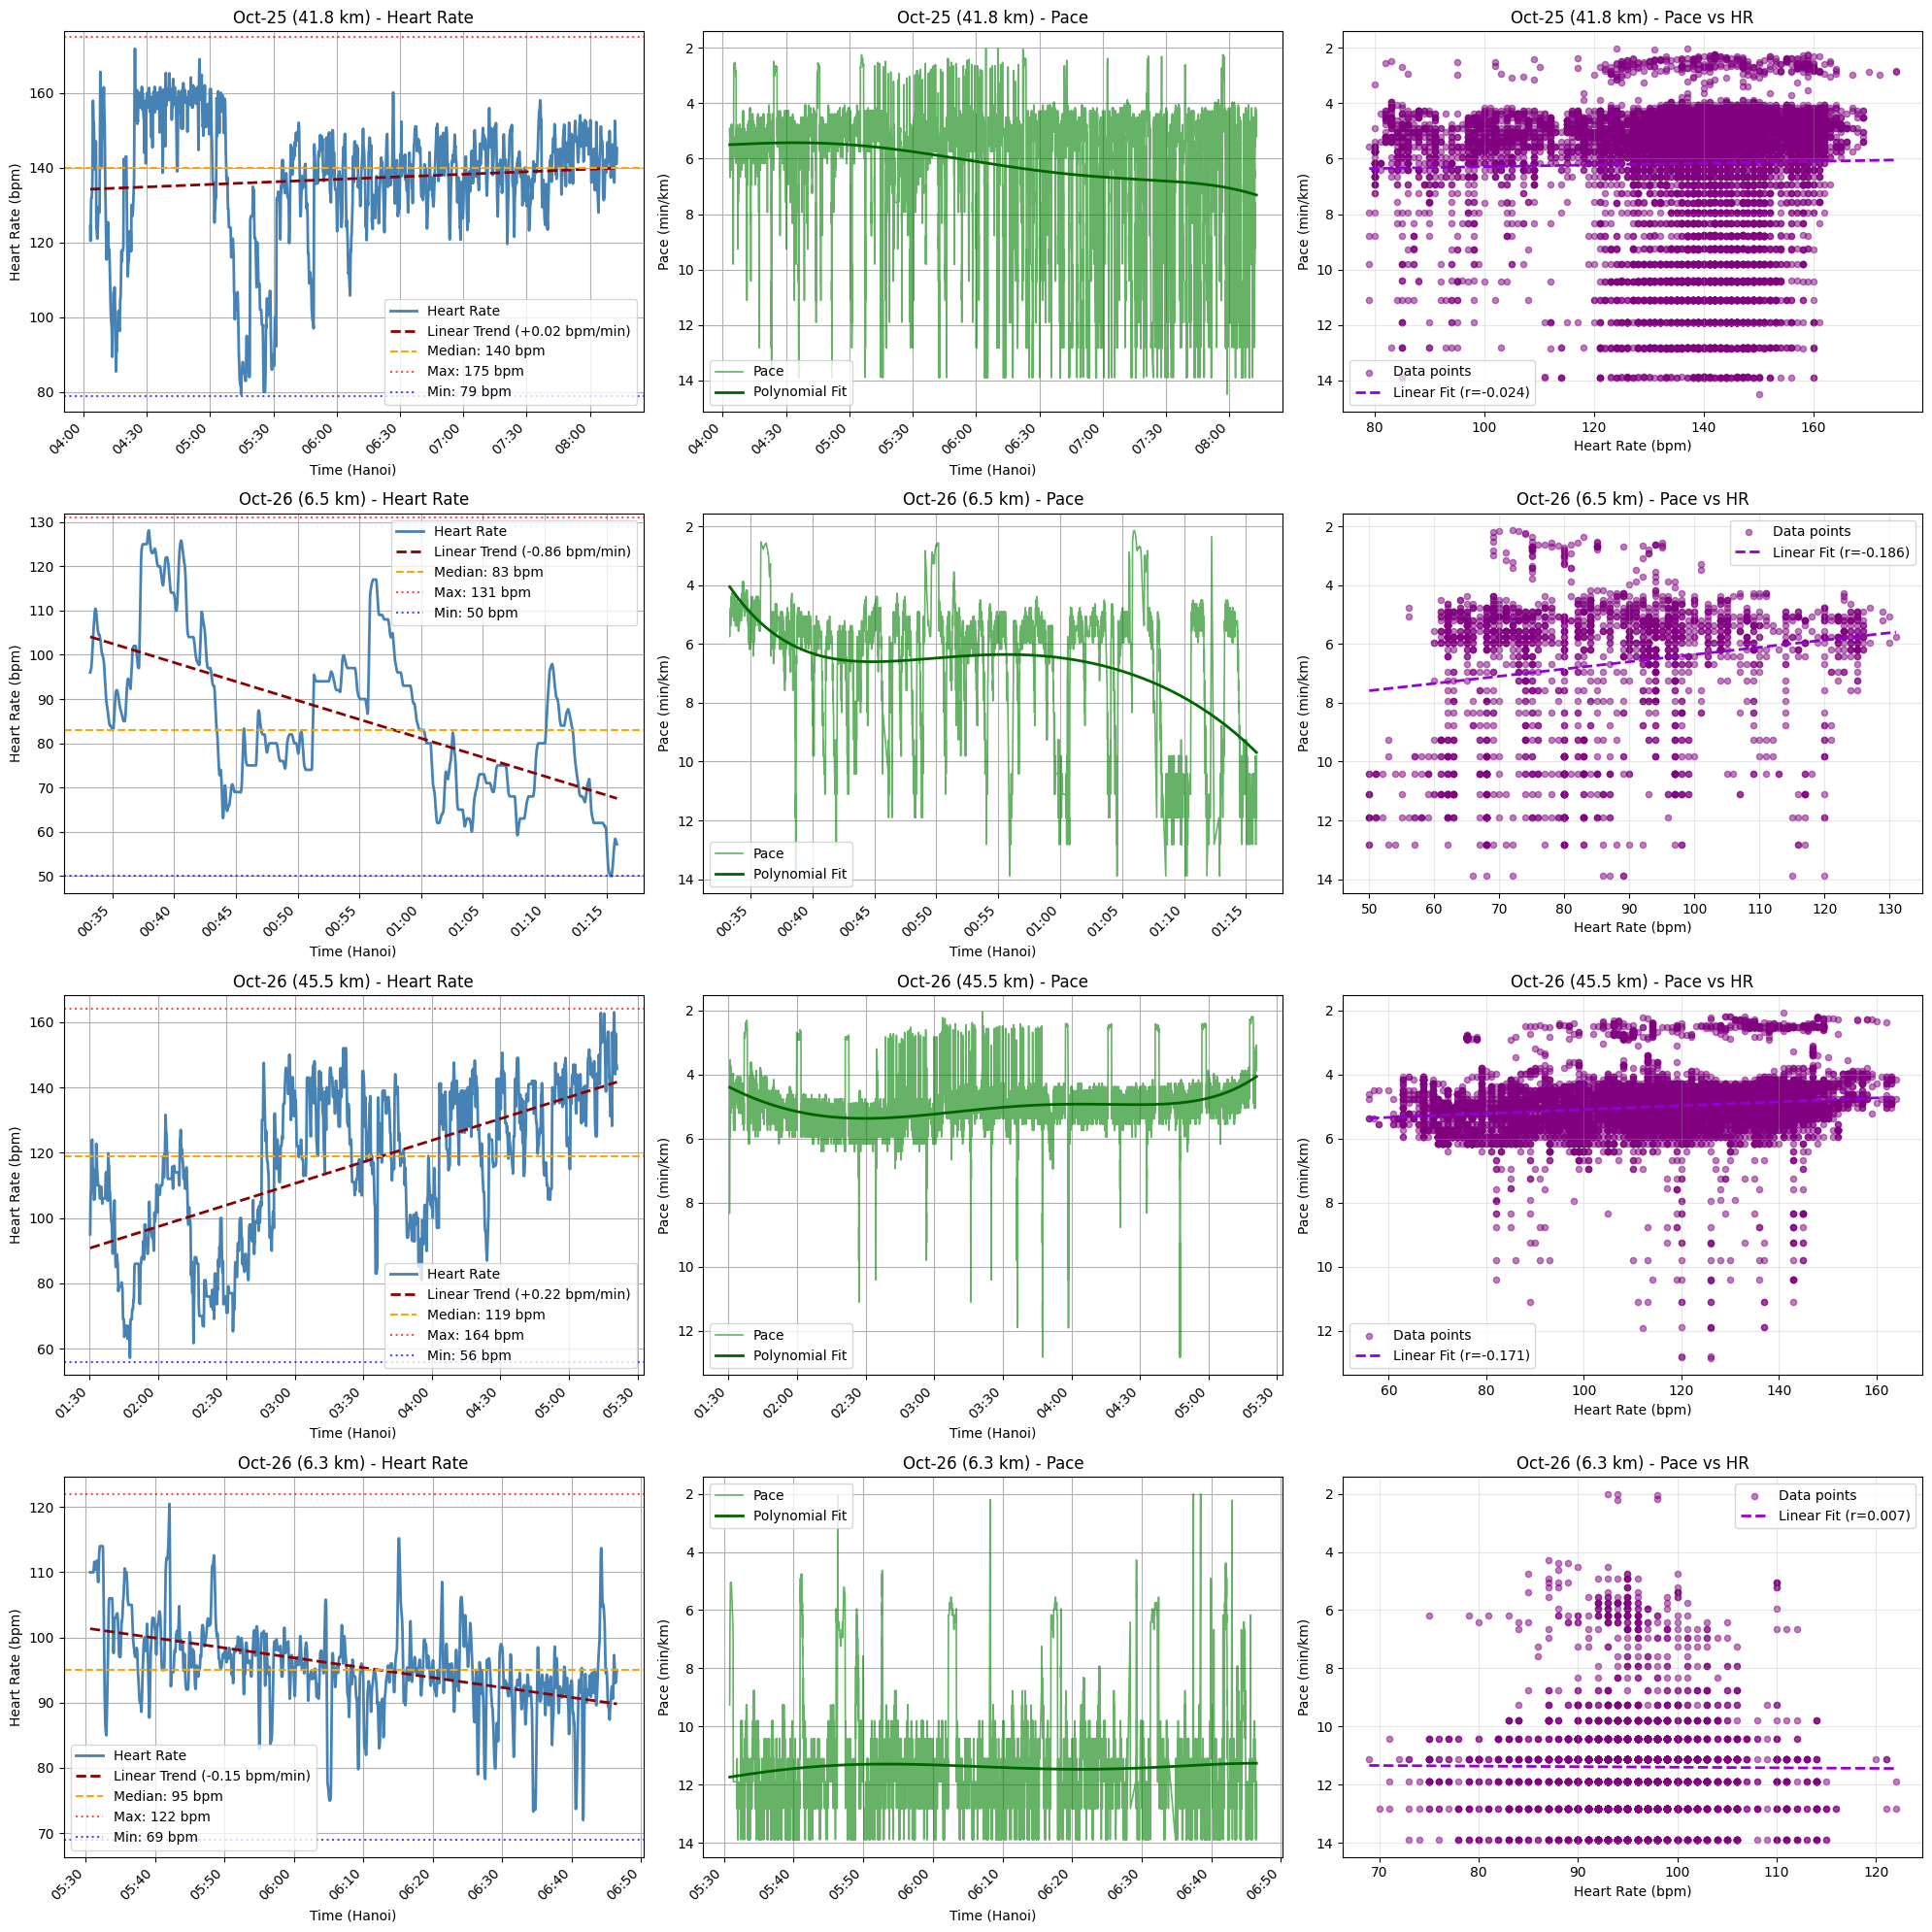

In [18]:
import os
import glob
import xml.etree.ElementTree as ET
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pytz
import matplotlib.dates as mdates

# === CONFIG ===
DIRECTORY = "/content"  # change to your directory
HANOI_TZ = pytz.timezone("Asia/Ho_Chi_Minh")
POLY_DEGREE = 5  # degree of polynomial for smoothing

# === HELPER: READ TCX FILE ===
def read_tcx(file):
    tree = ET.parse(file)
    root = tree.getroot()
    ns = {"tcx": "http://www.garmin.com/xmlschemas/TrainingCenterDatabase/v2"}
    times, hrs, dists = [], [], []

    for trackpoint in root.findall(".//tcx:Trackpoint", ns):
        time_elem = trackpoint.find("tcx:Time", ns)
        hr_elem = trackpoint.find(".//tcx:HeartRateBpm/tcx:Value", ns)
        dist_elem = trackpoint.find("tcx:DistanceMeters", ns)

        if time_elem is not None and hr_elem is not None:
            try:
                utc_time = datetime.fromisoformat(time_elem.text.replace("Z", "+00:00"))
                local_time = utc_time.astimezone(HANOI_TZ)
                hr = int(hr_elem.text)
                dist = float(dist_elem.text) if dist_elem is not None else np.nan
                times.append(local_time)
                hrs.append(hr)
                dists.append(dist)
            except Exception:
                continue

    if not times:
        return None

    df = pd.DataFrame({"Time": times, "HR": hrs, "Distance": dists})
    df = df.sort_values("Time").reset_index(drop=True)

    # Calculate pace (min/km)
    df["TimeDelta"] = (df["Time"] - df["Time"].iloc[0]).dt.total_seconds()
    df["DistDelta"] = df["Distance"].diff()
    df["TimeDiff"] = df["TimeDelta"].diff()

    # Pace in min/km: (time in minutes) / (distance in km)
    df["Pace"] = (df["TimeDiff"] / 60) / (df["DistDelta"] / 1000)

    # Filter out unrealistic pace values (e.g., stopped, GPS errors)
    df.loc[(df["Pace"] < 2) | (df["Pace"] > 15), "Pace"] = np.nan

    return df

# === READ ALL FILES ===
files = sorted(glob.glob(os.path.join(DIRECTORY, "*.TCX")))
if not files:
    raise FileNotFoundError(f"No .TCX files found in {DIRECTORY}")

# === PLOT EACH FILE ===
fig, axes = plt.subplots(len(files), 3, figsize=(20, 5 * len(files)), sharex=False)
if len(files) == 1:
    axes = axes.reshape(1, -1)  # handle case of only one file

for i, file in enumerate(files):
    df = read_tcx(file)
    if df is None or df.empty:
        continue

    ax_hr = axes[i, 0]
    ax_pace = axes[i, 1]
    ax_correlation = axes[i, 2]

    # === HEART RATE PLOT ===
    # Convert time to relative seconds for polynomial fitting
    t0 = df["Time"].min()
    x = (df["Time"] - t0).dt.total_seconds().values
    y_hr = df["HR"].values

    # Calculate HR statistics
    hr_median = df["HR"].median()
    hr_max = df["HR"].max()
    hr_min = df["HR"].min()

    # Smooth HR data using rolling average
    df["HR_smooth"] = df["HR"].rolling(window=10, center=True, min_periods=1).mean()

    # Plot smoothed HR
    ax_hr.plot(df["Time"], df["HR_smooth"], label="Heart Rate", linewidth=2, color="steelblue")

    # Linear fit for HR
    coeffs_hr = np.polyfit(x, y_hr, 1)  # degree 1 = linear
    linear_hr = np.poly1d(coeffs_hr)
    x_smooth_hr = np.linspace(x.min(), x.max(), 500)
    y_smooth_hr = linear_hr(x_smooth_hr)
    time_smooth_hr = pd.to_datetime([t0 + pd.Timedelta(seconds=float(s)) for s in x_smooth_hr])

    # Calculate slope in bpm per minute
    slope_bpm_per_sec = coeffs_hr[0]
    slope_bpm_per_min = slope_bpm_per_sec * 60

    ax_hr.plot(time_smooth_hr, y_smooth_hr, color="darkred",
              linewidth=2, linestyle="--",
              label=f"Linear Trend ({slope_bpm_per_min:+.2f} bpm/min)")

    # Plot median, max, min lines
    ax_hr.axhline(hr_median, color="orange", linestyle="--", linewidth=1.5,
                  label=f"Median: {hr_median:.0f} bpm")
    ax_hr.axhline(hr_max, color="red", linestyle=":", linewidth=1.5,
                  label=f"Max: {hr_max:.0f} bpm", alpha=0.7)
    ax_hr.axhline(hr_min, color="blue", linestyle=":", linewidth=1.5,
                  label=f"Min: {hr_min:.0f} bpm", alpha=0.7)

    # === PACE PLOT ===
    # Plot pace with valid values only
    pace_valid = df.dropna(subset=["Pace"])
    if not pace_valid.empty:
        ax_pace.plot(pace_valid["Time"], pace_valid["Pace"],
                     label="Pace", linewidth=1.2, alpha=0.6, color="green")

        # Polynomial smooth fit for pace
        try:
            x_pace = (pace_valid["Time"] - t0).dt.total_seconds().values
            y_pace = pace_valid["Pace"].values
            coeffs_pace = np.polyfit(x_pace, y_pace, POLY_DEGREE)
            poly_pace = np.poly1d(coeffs_pace)
            x_smooth_pace = np.linspace(x_pace.min(), x_pace.max(), 500)
            y_smooth_pace = poly_pace(x_smooth_pace)
            time_smooth_pace = pd.to_datetime([t0 + pd.Timedelta(seconds=float(s)) for s in x_smooth_pace])
            ax_pace.plot(time_smooth_pace, y_smooth_pace, color="darkgreen",
                        linewidth=2, label=f"Polynomial Fit")
        except (np.RankWarning, Exception):
            pass

    # === PACE vs HR CORRELATION PLOT ===
    # Merge HR with valid pace data
    corr_data = df.dropna(subset=["Pace"]).copy()
    if not corr_data.empty and len(corr_data) > 1:
        # Scatter plot
        ax_correlation.scatter(corr_data["HR"], corr_data["Pace"],
                              alpha=0.5, s=20, color="purple", label="Data points")

        # Calculate correlation coefficient
        correlation = corr_data[["HR", "Pace"]].corr().iloc[0, 1]

        # Linear fit
        hr_vals = corr_data["HR"].values
        pace_vals = corr_data["Pace"].values
        coeffs_corr = np.polyfit(hr_vals, pace_vals, 1)
        linear_corr = np.poly1d(coeffs_corr)
        hr_range = np.linspace(hr_vals.min(), hr_vals.max(), 100)
        pace_fit = linear_corr(hr_range)

        ax_correlation.plot(hr_range, pace_fit, color="darkviolet",
                          linewidth=2, linestyle="--",
                          label=f"Linear Fit (r={correlation:.3f})")

        ax_correlation.set_xlabel("Heart Rate (bpm)")
        ax_correlation.set_ylabel("Pace (min/km)")
        ax_correlation.invert_yaxis()  # Faster pace at top
        ax_correlation.grid(True, alpha=0.3)
        ax_correlation.legend()

    # === TITLE: Month - Day (xx km distance) ===
    date_str = df["Time"].iloc[0].strftime("%b-%d")
    dist_km = df["Distance"].dropna().iloc[-1] / 1000 if df["Distance"].notna().any() else 0
    title = f"{date_str} ({dist_km:.1f} km)"

    # === FORMAT AXES ===
    for ax in [ax_hr, ax_pace]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=HANOI_TZ))
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        ax.set_xlabel("Time (Hanoi)")
        ax.grid(True)
        ax.legend()

    ax_hr.set_title(f"{title} - Heart Rate")
    ax_hr.set_ylabel("Heart Rate (bpm)")

    ax_pace.set_title(f"{title} - Pace")
    ax_pace.set_ylabel("Pace (min/km)")
    ax_pace.invert_yaxis()  # Invert so faster pace (lower numbers) is at top

    ax_correlation.set_title(f"{title} - Pace vs HR")

plt.tight_layout()
plt.show()